In [1]:
import os
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from utils.config_reader import ConfigReader
from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_output_dir(config):
    return os.path.expandvars(config['train']['result_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['train']['input_dir'])

def load_config(config_file):
    return ConfigReader(config_file).cfg

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('name')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model


In [3]:
config_file = '../configs/evaluate_config.yaml'

In [4]:
config = load_config(config_file)
summaries = load_summaries(config)

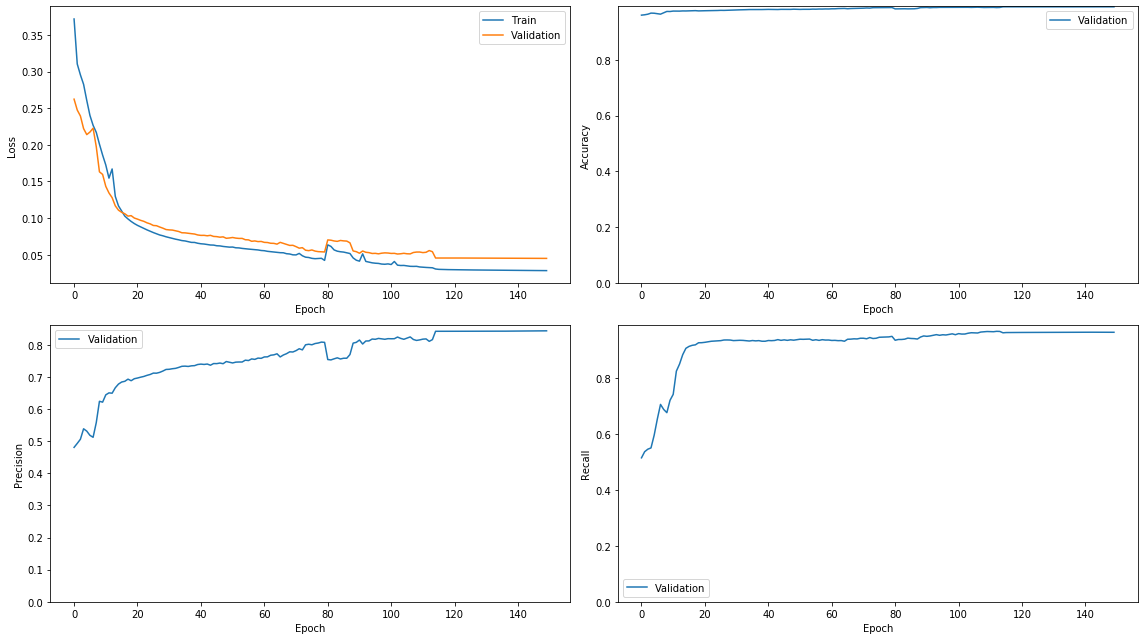

In [5]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

ax2.plot(summaries['epoch'], summaries['valid_prec_t'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Precision')
ax2.set_ylim(bottom=0, )
ax2.legend(loc=0)

ax3.plot(summaries['epoch'], summaries['valid_rec_t'], label='Validation')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Recall')
ax3.set_ylim(bottom=0, )
ax3.legend(loc=0)

plt.tight_layout()

In [6]:
model = load_model(config, reload_epoch=99).eval()

loading model


In [7]:
from utils.old_visualizer import Visualizer, draw_single
from utils.config_reader import ConfigReader
from utils.utils import get_events_df, parse_df, calc_purity_reduce_factor, apply_edge_restriction, apply_node_restriction
from utils.graph import to_nx_graph, to_line_graph, get_weight_stats, \
    get_linegraph_superedges_stat, to_pandas_graph_df, get_linegraph_stats_from_pandas, \
    get_reduced_df_graph, get_pd_line_graph, run_mbt_graph
from prepare import construct_output_graph
from matplotlib.ticker import FuncFormatter

In [8]:
cfg = {'df': {'df_path': '../data/train/CC4GeVmb_100_n50k.tsv',
              'event_ids': ['0..100'],
              'read_only_first_lines': 255000,
              'drop_broken_tracks': False,
              'convert_to_polar': False,
              'normalize': False,
              'stations_sizes': [[[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[27.7, -4.5, 66, 41], [-34.7, -4.3, 66, 41]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]]], 'z_stations': [32.85, 65.25, 96.65, 129.35, 161.25, 193.85]}, 
       'visualize': {'draw_scatters_for_tracks': True, 
                     'mode': '2d', 'drop_fake_percent': 0}, 
       'prepare': {'output_dir': '5_features_6k', 
                   'restrictions': {'x_min_max': [-0.15, 0.25], 'y_min_max': [-0.3, 0.22], 'weight_max': 0.09}}, 
       'with_stdout': False}
df = parse_df(cfg['df'])
events = get_events_df(cfg['df'], df, preserve_fakes=True)



In [38]:
def pandas_G_to_drawable(pandas_G, suffix='_prev'):
        return pandas_G.rename(columns={'x' + suffix:'x','y' + suffix:'y', 'station'+ suffix:'station'})

def get_nodes_from_G(G):    
    n_from = pandas_G_to_drawable(G, '_prev')
    n_to = pandas_G_to_drawable(G, '_current')
    
    n_from_true = n_from[(n_from.track_prev == n_from.track_current) & (n_from.track_prev != -1)]
    n_from_false = n_from[(n_from.track_prev == -1) | (n_from.track_current == -1)]
    
    n_to_true = n_to[(n_to.track_prev == n_to.track_current) & (n_to.track_prev != -1)]
    n_to_false = n_to[(n_to.track_prev == -1) | (n_to.track_current == -1)]
    return (n_from_true, n_from_false), (n_to_true, n_to_false)

def apply_edge_restrict_new(edges, WEIGHT=0.09):
    return apply_edge_restriction(edges, WEIGHT)

In [39]:
def get_result_from_pure_event(event):
    G = to_pandas_graph_df(event)

    def get_like_hitgraph_from_linegraph(df):
        df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
        return df
        
    
    def restrict_func(df):
        return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])
    

    
    result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)
    lg_full = result[1]
    
    edges_filtered = apply_edge_restrict_new(lg_full)
    pur_e, red_e = calc_purity_reduce_factor(result[1], edges_filtered)
    
    output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])
    b_input, b_target = collate_fn([output_graph])
    test_pred = model(b_input).flatten().detach().numpy()
    test_target = b_target.flatten().detach().numpy()
    thresh = 0.5
    y_pred, y_true = (test_pred > thresh), (test_target > thresh)
    return sklearn.metrics.accuracy_score(y_true, y_pred), sklearn.metrics.precision_score(y_true, y_pred),\
                sklearn.metrics.recall_score(y_true, y_pred), pur_e, red_e
#     print('Test set results with threshold of', thresh)
#     print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
#     print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
#     print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))
#     print("Node count:", len(event))
#     print("Edge count:", len(G))
#     print("Purity:", np.mean(result[2]))
#     print("Reduce factor:", np.mean(result[3]))


In [45]:
acc = []
rec = []
prec = []
pur_e = []
red_e = []
ev_ids = []

for ev_id, event_df in events.groupby('event'):
    acc_t, prec_t, rec_t, pur, red = get_result_from_pure_event(event_df)
#     print("Processing event #%d. Accuracy: %.5f, Recall: %.5f, Precision: %.5f."
#           "Reduce: %.5f, Purity: %.5f" % (ev_id, acc_t, rec_t, prec_t, red, pur))
    acc.append(acc_t)
    rec.append(rec_t)
    prec.append(prec_t)
    pur_e.append(pur)
    red_e.append(red)
    ev_ids.append(ev_id)


In [46]:
print('Accuracy:  %.5f' % np.mean(acc))
print('Recall: %.5f' % np.mean(rec))
print('Precision:    %.5f' % np.mean(prec))
print('Edge purity:    %.5f' % np.mean(pur_e))
print('Edge reduce:    %.5f' % np.mean(red_e))


Accuracy:  0.98198
Recall: 0.95540
Precision:    0.82781
Edge purity:    0.99748
Edge reduce:    4.83918


In [49]:
ev_ids[np.argmin(rec)]

1176

In [66]:
def visualize_single_event(ev_id, df):
    event = df[df.event == ev_id]
    vis = Visualizer(event, cfg['visualize'], title='EVENT GRAPH', random_seed=14)
    vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)

    fig, (ax, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
    vis.draw_2d(ax)
    ax.set_title('')
    ax.set_xlabel('Y')
    G = to_pandas_graph_df(event)
    (n_from_true, n_from_false), (n_to_true, n_to_false) = get_nodes_from_G(G)

    vis.draw_edges_from_nodes_2d(ax, n_from_true, n_to_true, 'orange','tab:blue', 6, 10,1, 'y', 10)
    vis.draw_edges_from_nodes_2d(ax, n_from_false, n_to_false, [0.2,0.2,0.2, 0.0], [0.2,0.2,0.2, 0.5], 3, 9,1, 'y',10)

    
    G = to_pandas_graph_df(event)
    (n_from_true, n_from_false), (n_to_true, n_to_false) = get_nodes_from_G(G)
    ax1.set_title('')
    ax1.set_xlabel('X')
    vis.draw_edges_from_nodes_2d(ax1, n_from_true, n_to_true, 'orange','tab:blue', 6, 10,1, 'x',10)
    vis.draw_edges_from_nodes_2d(ax1, n_from_false, n_to_false, [0.2,0.2,0.2, 0.0], [0.2,0.2,0.2, 0.5], 3, 9,1, 'x',10)

    fig.suptitle('asdasd')

    
def visualize_network_prediction(ev_id, df):
    event = df[df.event == ev_id]
    G = to_pandas_graph_df(event)

    def get_like_hitgraph_from_linegraph(df):
        df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
        return df
        
    
    def restrict_func(df):
        return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])
    

    
    result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)
    lg_full = result[1]
    
    edges_filtered = apply_edge_restrict_new(lg_full)
    output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])
    b_input, b_target = collate_fn([output_graph])
    test_pred = model(b_input).flatten().detach().numpy()
    test_target = b_target.flatten().detach().numpy()
    thresh = 0.5
    y_pred, y_true = (test_pred > thresh), (test_target > thresh)
    
    X, Ri, Ro, y = output_graph
    print("ACC:", sklearn.metrics.accuracy_score(y_true, y_pred), "Prec:", sklearn.metrics.precision_score(y_true, y_pred),\
                "Rec:", sklearn.metrics.recall_score(y_true, y_pred))
    draw_single(X, Ri, Ro, y_pred, c_fake=(0,0,0,0.0), xcord1=(1, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
    draw_single(X, Ri, Ro, y_true, c_fake=(0,0,0,0.0), xcord1=(1, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
    
def visualize_supergraph(ev_id, df):    
    event = df[df.event == ev_id]
    G = to_pandas_graph_df(event)
    
    def get_like_hitgraph_from_linegraph(df):
        df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
        return df
    
    def restrict_func(df):
        return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])
    

    result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)

    print(np.mean(result[2]), np.mean(result[3]))

    vis = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH', random_seed=14)
    vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
    vis.add_edges_data(result[1])
    
    edges_filtered = apply_edge_restrict_new(result[1])
    print(calc_purity_reduce_factor(result[1], edges_filtered))
    
    vis1 = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH FILTERED', random_seed=14)
    vis1.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
    vis1.add_edges_data(edges_filtered)
    
    
    fig = plt.figure(figsize=(18, 9))
    ax0 = plt.subplot(121)
    ax1 = plt.subplot(122)
    
    ax0 = vis.draw(ax=ax0, show=False)
    ax1 = vis1.draw(ax=ax1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

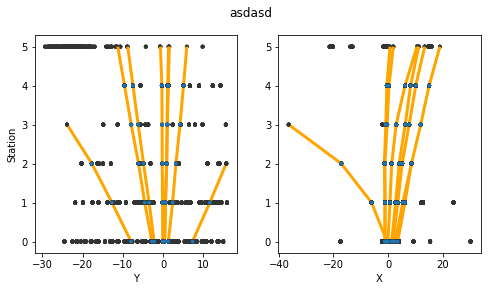

<Figure size 432x432 with 0 Axes>

In [67]:
visualize_single_event(2, events)

ACC: 0.979708306911858 Prec: 0.2777777777777778 Rec: 0.625


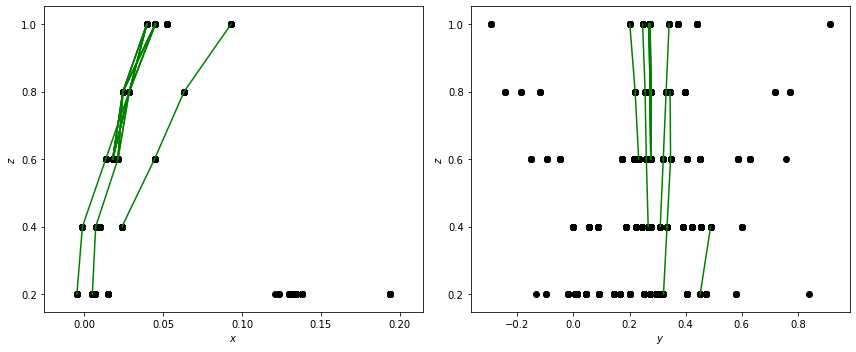

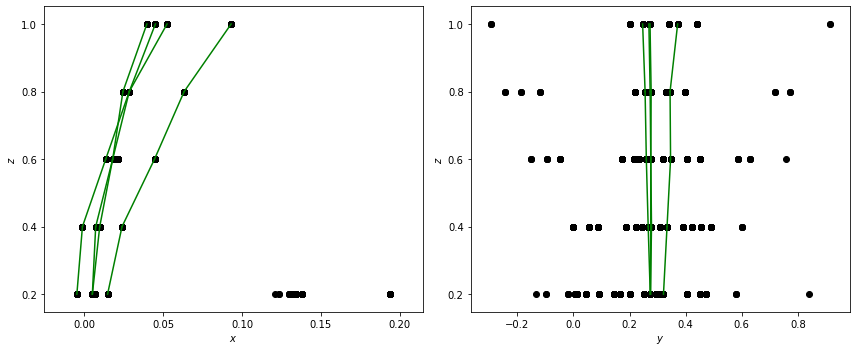

In [113]:
visualize_network_prediction(1065, events)

In [354]:
visualize_supergraph(506, events)

AssertionError: 

In [79]:
ev_id = 1036

event = events[events.event == ev_id]
G = to_pandas_graph_df(event)

def get_like_hitgraph_from_linegraph(df):
    df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
    return df
    

def restrict_func(df):
    return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])



result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)
lg_full = result[1]
lg_nodes = result[0]
edges_filtered = apply_edge_restrict_new(lg_full)
output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])

b_input, b_target = collate_fn([output_graph])
test_pred = model(b_input).flatten().detach().numpy()
test_target = b_target.flatten().detach().numpy()
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)

In [71]:
y_pred.shape, len(edges_filtered)

((376,), 376)

In [82]:
pred_edges = edges_filtered.loc[y_pred]

In [89]:
pred_hits = lg_nodes.loc[pred_edges.edge_index_p]
cur_hits = lg_nodes.loc[pred_edges.edge_index_c]
total_hits = pred_hits.append(cur_hits, ignore_index=False, sort=False)
total_hits = total_hits.loc[~total_hits.index.duplicated(keep='first')]

In [92]:
total_hits

,dx,dy,x_p,x_c,y_p,y_c,dz,z,from_ind,to_ind,track,station
0,-0.049998,0.057839,-0.104625,-0.154622,0.391617,0.449456,0.200000,0.2,123425,123426,3,0
36,-0.001825,0.018220,-0.013973,-0.015798,0.319357,0.337577,0.200000,0.2,123437,123438,23,0
54,0.008923,0.026833,0.005324,0.014247,0.337356,0.364189,0.200000,0.2,123443,123444,24,0
38,0.006602,0.011545,-0.013973,-0.007371,0.319357,0.330902,0.200000,0.2,123437,123450,-1,0
72,0.002147,0.014441,-0.009517,-0.007371,0.316461,0.330902,0.200000,0.2,123449,123450,25,0
18,0.015400,-0.087995,0.007639,0.023039,0.144011,0.056015,0.200000,0.2,123431,123432,22,0
306,-0.048013,0.057496,-0.154622,-0.202635,0.449456,0.506952,0.193827,0.4,123426,123427,3,1
342,-0.004992,0.015757,-0.015798,-0.020790,0.337577,0.353334,0.193827,0.4,123438,123439,23,1
360,0.004842,0.029836,0.014247,0.019089,0.364189,0.394025,0.193827,0.4,123444,123445,24,1
378,0.000528,0.016754,-0.007371,-0.006842,0.330902,0.347656,0.193827,0.4,123450,123451,25,1


In [98]:
hits_from = event.loc[total_hits.from_ind]
hits_to = event.loc[total_hits.to_ind]
result_hits = hits_from.append(hits_to, ignore_index=False, sort=False)
result_hits = result_hits.loc[~result_hits.index.duplicated(keep='first')]

In [103]:
hit_accur = []

true_tracks = event[event.track != -1]
for tr_id, track in true_tracks.groupby('track'):
    if len(track) == len(result_hits[result_hits.track == tr_id]):
        hit_accur.append(1)
    else:
        hit_accur.append(0)

accur = len(result_hits[result_hits.track != -1]) / len(event[event.track != -1])
hit_accuracy = np.mean(hit_accur)



1.0

In [169]:
def calc_total_accur(event):
    G = to_pandas_graph_df(event)

    def get_like_hitgraph_from_linegraph(df):
        df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
        return df
        
    
    def restrict_func(df):
        return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])
    
    
    
    result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)
    lg_full = result[1]
    lg_nodes = result[0]
    edges_filtered = apply_edge_restrict_new(lg_full)
    output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])
    
    b_input, b_target = collate_fn([output_graph])
    test_pred = model(b_input).flatten().detach().numpy()
    test_target = b_target.flatten().detach().numpy()
    thresh = 0.5
    y_pred, y_true = (test_pred > thresh), (test_target > thresh)
    
    pred_edges = edges_filtered.loc[y_pred]
    
    pred_hits = lg_nodes.loc[pred_edges.edge_index_p]
    cur_hits = lg_nodes.loc[pred_edges.edge_index_c]
    total_hits = pred_hits.append(cur_hits, ignore_index=False, sort=False)
    total_hits = total_hits.loc[~total_hits.index.duplicated(keep='first')]
    
    hits_from = event.loc[total_hits.from_ind]
    hits_to = event.loc[total_hits.to_ind]
    result_hits = hits_from.append(hits_to, ignore_index=False, sort=False)
    result_hits = result_hits.loc[~result_hits.index.duplicated(keep='first')]
    
    
    hit_accur = []

    true_tracks = event[event.track != -1]
    for tr_id, track in true_tracks.groupby('track'):
        if len(track) == len(result_hits[result_hits.track == tr_id]):
            hit_accur.append(1)
        else:
            hit_accur.append(0)
    
    hit_accuracy = len(result_hits[result_hits.track != -1]) / len(event[event.track != -1])
    track_accuracy = np.mean(hit_accur)
    hit_precision = len(result_hits[result_hits.track != -1]) / len(result_hits)
    return hit_accuracy, track_accuracy, hit_precision

In [249]:
hit_acc = []
track_acc = []
hit_p = []
hit_c = []

for ev_id, event_df in events.groupby('event'):
    hit_acc_t, track_acc_t, hit_prec_t = calc_total_accur(event_df)
    
    print("Processing event #%d. Hit accuracy: %.5f, Track accuracy: %.5f, Hit precision %.5f"
          " " % (ev_id, hit_acc_t, track_acc_t, hit_prec_t))
    hit_acc.append(hit_acc_t)
    track_acc.append(track_acc_t)
    hit_c.append(len(event_df))
    hit_p.append(hit_prec_t)


Processing event #510. Hit accuracy: 0.78261, Track accuracy: 0.75000, Hit precision 1.00000 
Processing event #511. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.85714 
Processing event #512. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #513. Hit accuracy: 0.74000, Track accuracy: 0.54545, Hit precision 0.57812 
Processing event #514. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.92308 
Processing event #515. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.88889 
Processing event #516. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #517. Hit accuracy: 0.92593, Track accuracy: 0.80000, Hit precision 0.92593 
Processing event #518. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.95652 
Processing event #519. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #520. Hit accuracy: 1.00000, Track accuracy

Processing event #600. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.92593 
Processing event #601. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.96000 
Processing event #602. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.93750 
Processing event #604. Hit accuracy: 0.78261, Track accuracy: 0.66667, Hit precision 0.81818 
Processing event #605. Hit accuracy: 0.93750, Track accuracy: 0.66667, Hit precision 1.00000 
Processing event #606. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #607. Hit accuracy: 0.86207, Track accuracy: 0.60000, Hit precision 1.00000 
Processing event #608. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.98077 
Processing event #609. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #610. Hit accuracy: 0.95455, Track accuracy: 0.75000, Hit precision 0.89362 
Processing event #611. Hit accuracy: 1.00000, Track accuracy

Processing event #693. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #694. Hit accuracy: 0.85714, Track accuracy: 0.75000, Hit precision 0.94737 
Processing event #695. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #696. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #697. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.97222 
Processing event #698. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #699. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.85714 
Processing event #700. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #702. Hit accuracy: 0.65385, Track accuracy: 0.57143, Hit precision 0.68000 
Processing event #703. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #704. Hit accuracy: 1.00000, Track accuracy

Processing event #786. Hit accuracy: 0.90625, Track accuracy: 0.83333, Hit precision 1.00000 
Processing event #787. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #788. Hit accuracy: 0.97436, Track accuracy: 0.85714, Hit precision 0.97436 
Processing event #789. Hit accuracy: 0.86000, Track accuracy: 0.72727, Hit precision 0.79630 
Processing event #790. Hit accuracy: 0.79310, Track accuracy: 0.40000, Hit precision 0.71875 
Processing event #791. Hit accuracy: 0.91071, Track accuracy: 0.80000, Hit precision 0.72857 
Processing event #792. Hit accuracy: 0.96429, Track accuracy: 0.83333, Hit precision 0.87097 
Processing event #793. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #794. Hit accuracy: 0.98000, Track accuracy: 0.88889, Hit precision 0.85965 
Processing event #795. Hit accuracy: 0.60000, Track accuracy: 0.50000, Hit precision 1.00000 
Processing event #796. Hit accuracy: 1.00000, Track accuracy

Processing event #878. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #879. Hit accuracy: 0.86667, Track accuracy: 0.77778, Hit precision 0.72222 
Processing event #880. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.93103 
Processing event #881. Hit accuracy: 0.54545, Track accuracy: 0.50000, Hit precision 1.00000 
Processing event #883. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #884. Hit accuracy: 0.95455, Track accuracy: 0.75000, Hit precision 1.00000 
Processing event #885. Hit accuracy: 0.68182, Track accuracy: 0.44444, Hit precision 0.53571 
Processing event #886. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #887. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #888. Hit accuracy: 0.75000, Track accuracy: 0.66667, Hit precision 0.92308 
Processing event #889. Hit accuracy: 1.00000, Track accuracy

Processing event #973. Hit accuracy: 0.94444, Track accuracy: 0.83333, Hit precision 0.77273 
Processing event #975. Hit accuracy: 0.93939, Track accuracy: 0.66667, Hit precision 0.75610 
Processing event #976. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #977. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.66667 
Processing event #978. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #979. Hit accuracy: 0.80488, Track accuracy: 0.75000, Hit precision 1.00000 
Processing event #980. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 0.96429 
Processing event #981. Hit accuracy: 0.81818, Track accuracy: 0.75000, Hit precision 1.00000 
Processing event #982. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #983. Hit accuracy: 1.00000, Track accuracy: 1.00000, Hit precision 1.00000 
Processing event #984. Hit accuracy: 1.00000, Track accuracy

In [250]:
print('Total stats on %d events:' % events.event.nunique())
print('Hit accuracy:  %.5f' % np.mean(hit_acc))
print('Hit precision: %.5f' % np.mean(hit_p))
print('Track accuracy: %.5f' % np.mean(track_acc))

Total stats on 468 events:
Hit accuracy:  0.94096
Hit precision: 0.91356
Track accuracy: 0.87081


In [130]:
hit_c

[291,
 53,
 293,
 164,
 20,
 315,
 170,
 3063,
 45,
 57,
 133,
 88,
 226,
 39,
 122,
 170,
 207,
 230,
 248,
 49,
 31,
 60,
 42,
 6,
 49,
 81,
 261,
 69,
 150,
 83,
 24,
 435,
 46,
 129,
 42,
 90,
 329,
 96,
 113,
 19,
 327,
 90,
 15,
 29,
 16,
 293,
 110,
 75,
 23,
 150,
 188,
 219,
 117,
 249,
 81,
 287,
 64,
 476,
 46,
 7,
 6,
 34,
 6,
 99,
 74,
 31,
 44,
 30,
 313,
 21,
 766,
 18,
 14,
 34,
 14,
 89,
 123,
 88,
 69,
 163,
 18,
 6,
 15,
 42,
 91,
 10,
 41,
 69,
 180,
 201,
 138,
 142,
 136,
 96,
 98,
 82,
 31,
 112,
 27,
 102,
 107,
 138,
 79,
 68,
 102,
 23,
 262,
 41,
 10,
 60,
 127,
 161,
 18,
 145,
 63,
 93,
 71,
 129,
 44,
 176,
 373,
 106,
 24,
 49,
 18,
 63,
 12,
 118,
 63,
 173,
 17,
 197,
 93,
 103,
 71,
 50,
 136,
 132,
 117,
 134,
 69,
 39,
 280,
 6,
 168,
 209,
 26,
 196,
 119,
 49,
 6,
 135,
 169,
 722,
 55,
 26,
 69,
 51,
 40,
 46,
 36,
 178,
 16,
 32,
 836,
 73,
 19,
 89,
 128,
 23,
 94,
 20,
 9,
 53,
 69,
 148,
 199,
 92,
 294,
 6,
 173,
 71,
 220,
 146,
 64,
 123,
 

Text(0, 0.5, 'Event count')

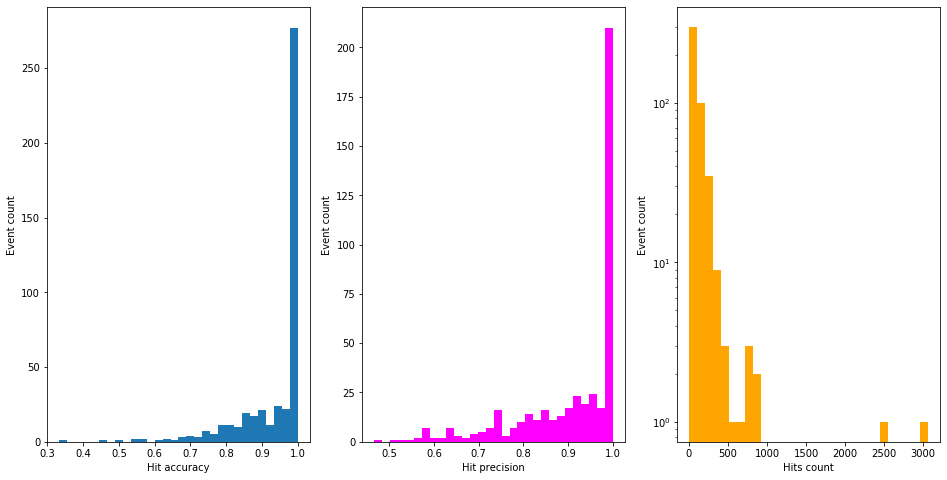

In [174]:
plt.figure(figsize=(16, 8))

plt.subplot(131)
binning = dict(bins=30)
plt.hist(hit_acc, label='aaaaa', log=False, **binning)
plt.xlabel('Hit accuracy')
plt.ylabel('Event count')
#plt.legend(loc=0)

plt.subplot(132)
binning = dict(bins=30)
plt.hist(hit_p, label='aaaaa', log=False, color='magenta', **binning)
plt.xlabel('Hit precision')
plt.ylabel('Event count')
#plt.legend(loc=0)

plt.subplot(133)
binning = dict(bins=30)
plt.hist(hit_c, label='aaaaa', log=True, color='orange', **binning)
plt.xlabel('Hits count')
plt.ylabel('Event count')
#plt.legend(loc=0)
# plt.subplot(122)
# res_true1 = lg_nodes[lg_nodes.track != -1][['dx']].values
# res_false1 = lg_nodes[lg_nodes.track == -1][['dx']].values
# binning = dict(bins=300, range=(-1.5, 1.5))
# plt.hist(res_false1, label='fake', log=True, **binning)
# plt.hist(res_true1, label='true', **binning)
# plt.xlabel('Track accuracy')
# plt.ylabel('count of nodes in supergraph')
# plt.legend(loc=0)

In [333]:
def get_res(arr_from, count_arr, bin_count=20):
    np_hit_acc = np.array(arr_from)
    np_hit_c = np.array(count_arr)
    
    res = np.zeros((bin_count,))
    res_err_min = np.zeros((bin_count,))
    res_err_max = np.zeros((bin_count,))
    
    for acc in range(1, bin_count + 1):
        bot = (acc-1) / (1.0*bin_count)
        top = acc / (1.0*bin_count)
        if len(np_hit_c[(bot < np_hit_acc) & (np_hit_acc <= top)]) > 0:
            
            vals = np_hit_c[(bot < np_hit_acc) & (np_hit_acc <= top)]
            res[acc-1] = vals.mean()
            res_err_min[acc-1] = vals.min()
            res_err_max[acc-1] = vals.max()
    inds = np.where(res > 0)
    res=res[inds]
    res_err_min=res_err_min[inds]
    res_err_max=res_err_max[inds]
    return res, res_err_min, res_err_max, inds


In [346]:
res, res_err_min, res_err_max, inds = get_res(hit_p, hit_c)
np.arange(1,len(inds[0])), res

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1049.66666667,  286.66666667,  245.18181818,  303.52941176,
         191.17391304,  190.95238095,  196.33333333,  134.23809524,
         123.03703704,   77.08571429]))

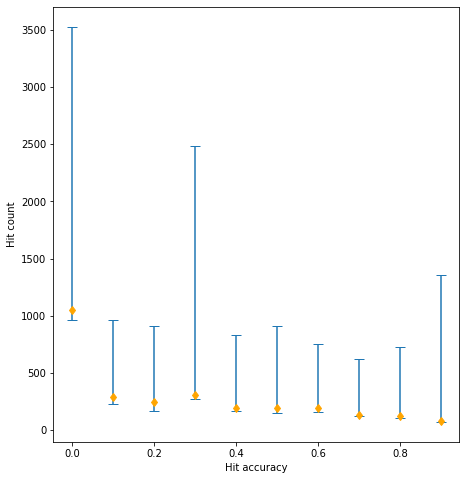

In [351]:
# import matplotlib
# matplotlib.rcParams.update({'errorbar.capsize': 5})
plt.figure(figsize=(16, 8))

res, res_err_min, res_err_max, inds = get_res(hit_p, hit_c)



plt.subplot(121)

plt.errorbar(np.arange(len(inds[0])), res, np.array([res_err_min, res_err_max]), label='aaaaa',
             fmt='d',color='orange', ecolor='tab:blue', capsize=5)
plt.xlabel('Hit accuracy')
plt.ylabel('Hit count')
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(float((x)/len(inds[0])), ',')))


# res1,res_err_min, res_err_max = get_res(track_acc, hit_c)
# plt.subplot(122)
# plt.errorbar(np.arange(1, bin_count+1), res1, np.array([res_err_min, res_err_max]), label='aaaaa',
#              fmt='d',color='orange', ecolor='tab:blue', capsize=5)
# plt.xlabel('Track accuracy')
# plt.ylabel('Hit count')
# plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(float(x/bin_count), ',')))

In [331]:
get_res(hit_p, hit_c)

(array([1049.66666667,  286.66666667,  245.18181818,  303.52941176,
         191.17391304,  190.95238095,  196.33333333,  134.23809524,
         123.03703704,   77.08571429]),
 array([90., 56., 80., 29., 22., 37., 34., 13., 16.,  6.]),
 array([2476.,  678.,  661., 2180.,  643.,  721.,  558.,  491.,  604.,
        1283.]))

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   90.,   56.,   80.,   29.,   22.,   37.,   34.,   13.,
          16.,    6.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 2476.,  678.,  661., 2180.,  643.,  721.,  558.,  491.,
         604., 1283.]])

In [96]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9943
Precision: 0.6667
Recall:    0.9167


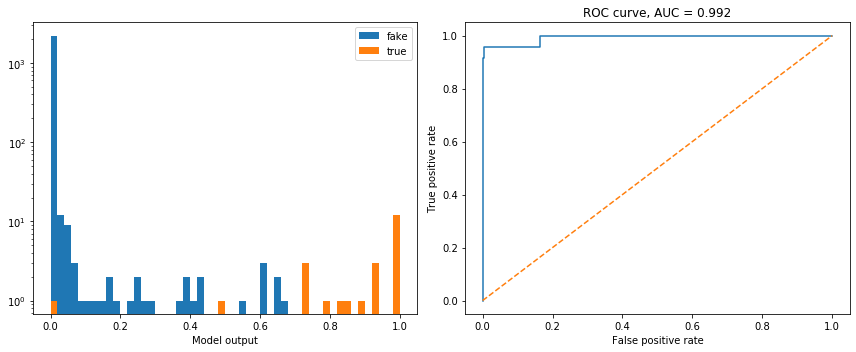

In [97]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

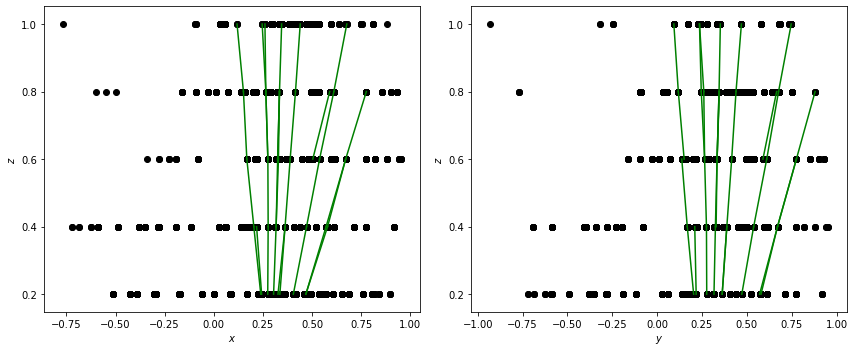

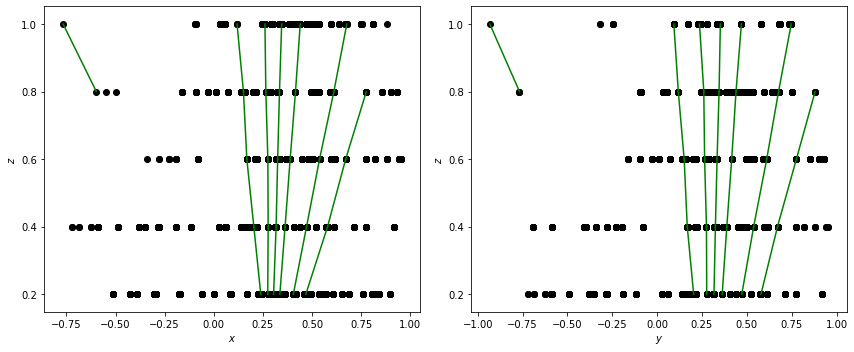

In [98]:
X, Ri, Ro, y = output_graph
draw_single(X, Ri, Ro, y_pred, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
draw_single(X, Ri, Ro, y_true, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
